In [1066]:
from functools import cmp_to_key

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# set matplotlib backend to inline
%matplotlib inline

# import modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit

In [1067]:

raw_nhl_data = pd.read_csv('moneypack/all_teams.csv')
columns_to_drop_from_total = ['name', 'gameId', 'playerTeam', 'opposingTeam', 'home_or_away', 'gameDate', 'position',
                              'situation', 'iceTime']
raw_nhl_data = raw_nhl_data.drop(columns=columns_to_drop_from_total)
raw_nhl_data = raw_nhl_data[(raw_nhl_data['season'] != '2023')]

raw_nhl_data_2023 = pd.read_csv('moneypack/all_teams_2023.csv')
raw_nhl_data_2023['playoffGame'] = [0] * len(raw_nhl_data_2023.index)
columns_to_drop_from_2023 = ['games_played', 'name', 'position', 'situation',  'iceTime']
raw_nhl_data_2023 = raw_nhl_data_2023.drop(columns=columns_to_drop_from_2023)

columns_all = raw_nhl_data.columns
columns_2023 = raw_nhl_data_2023.columns

by_team_season_all = raw_nhl_data.groupby(['team', 'season']).mean()
by_team_season_all['playoff_qualified'] = by_team_season_all['playoffGame'].apply(lambda val: 1 if val > 0.0 else 0)

X = by_team_season_all.drop(columns=['playoff_qualified', 'playoffGame'])
y = by_team_season_all['playoff_qualified']
print(f'all team qualified {y}')

teams = pd.DataFrame(raw_nhl_data_2023['team']).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

by_team_season_2023 = raw_nhl_data_2023.groupby(['team', 'season']).mean()
X_2023 = by_team_season_2023.drop(columns=[ 'playoffGame'])


all team qualified team  season
ANA   2008      1
      2009      0
      2010      1
      2011      0
      2012      1
               ..
WSH   2018      1
      2019      1
      2020      1
      2021      1
      2022      0
Name: playoff_qualified, Length: 458, dtype: int64


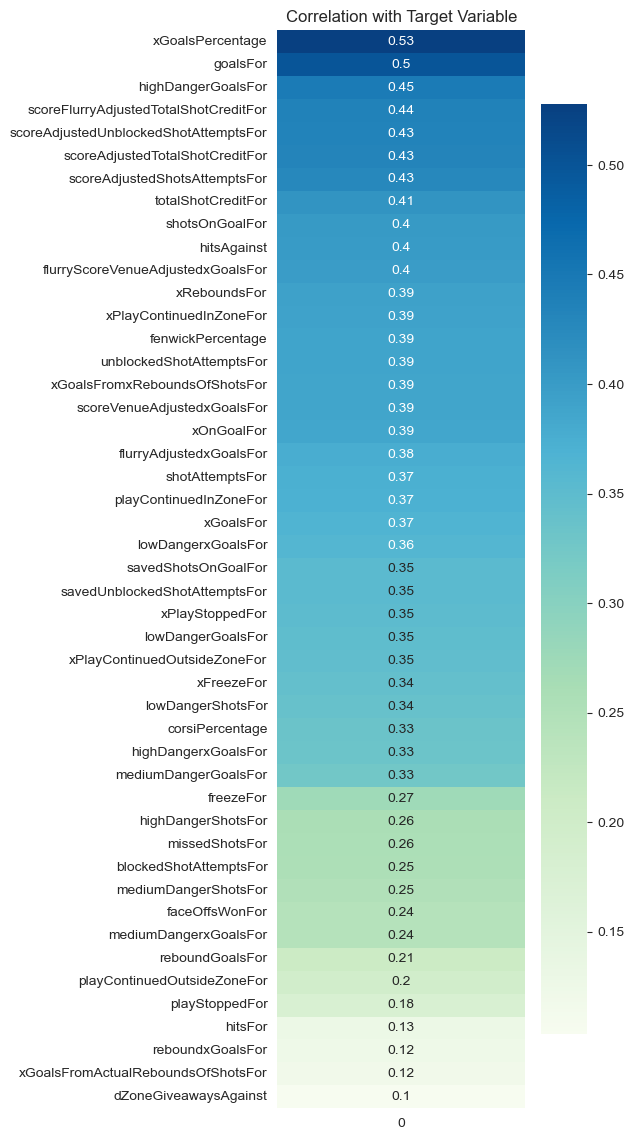

In [1068]:
corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
corr_with_target.reset_index(name='score')

# selected_corr_with_target = pd.DataFrame(corr_with_target, columns=['score'])
# selected_corr_with_target.columns = ["feature", "score"]

corr_with_target = corr_with_target.loc[lambda x: x > 0.1]
# print(corr_with_target.index)
# Plot the heatmap
plt.figure(figsize=(4, 14))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
# plt.show()

corr_with_target_frame = pd.DataFrame({"feature": corr_with_target.index, "score": corr_with_target.values})


                                  feature      score
0                             hitsAgainst  14.299582
1           scoreAdjustedShotsAttemptsFor  11.131982
2   scoreAdjustedUnblockedShotAttemptsFor   7.786677
3                         shotAttemptsFor   7.585925
4       scoreAdjustedShotsAttemptsAgainst   5.963264
..                                    ...        ...
94                     playStoppedAgainst   0.020615
95                           penaltiesFor   0.004046
96                       takeawaysAgainst   0.002860
97                 penalityMinutesAgainst   0.002602
98                      dZoneGiveawaysFor   0.000043

[99 rows x 2 columns]


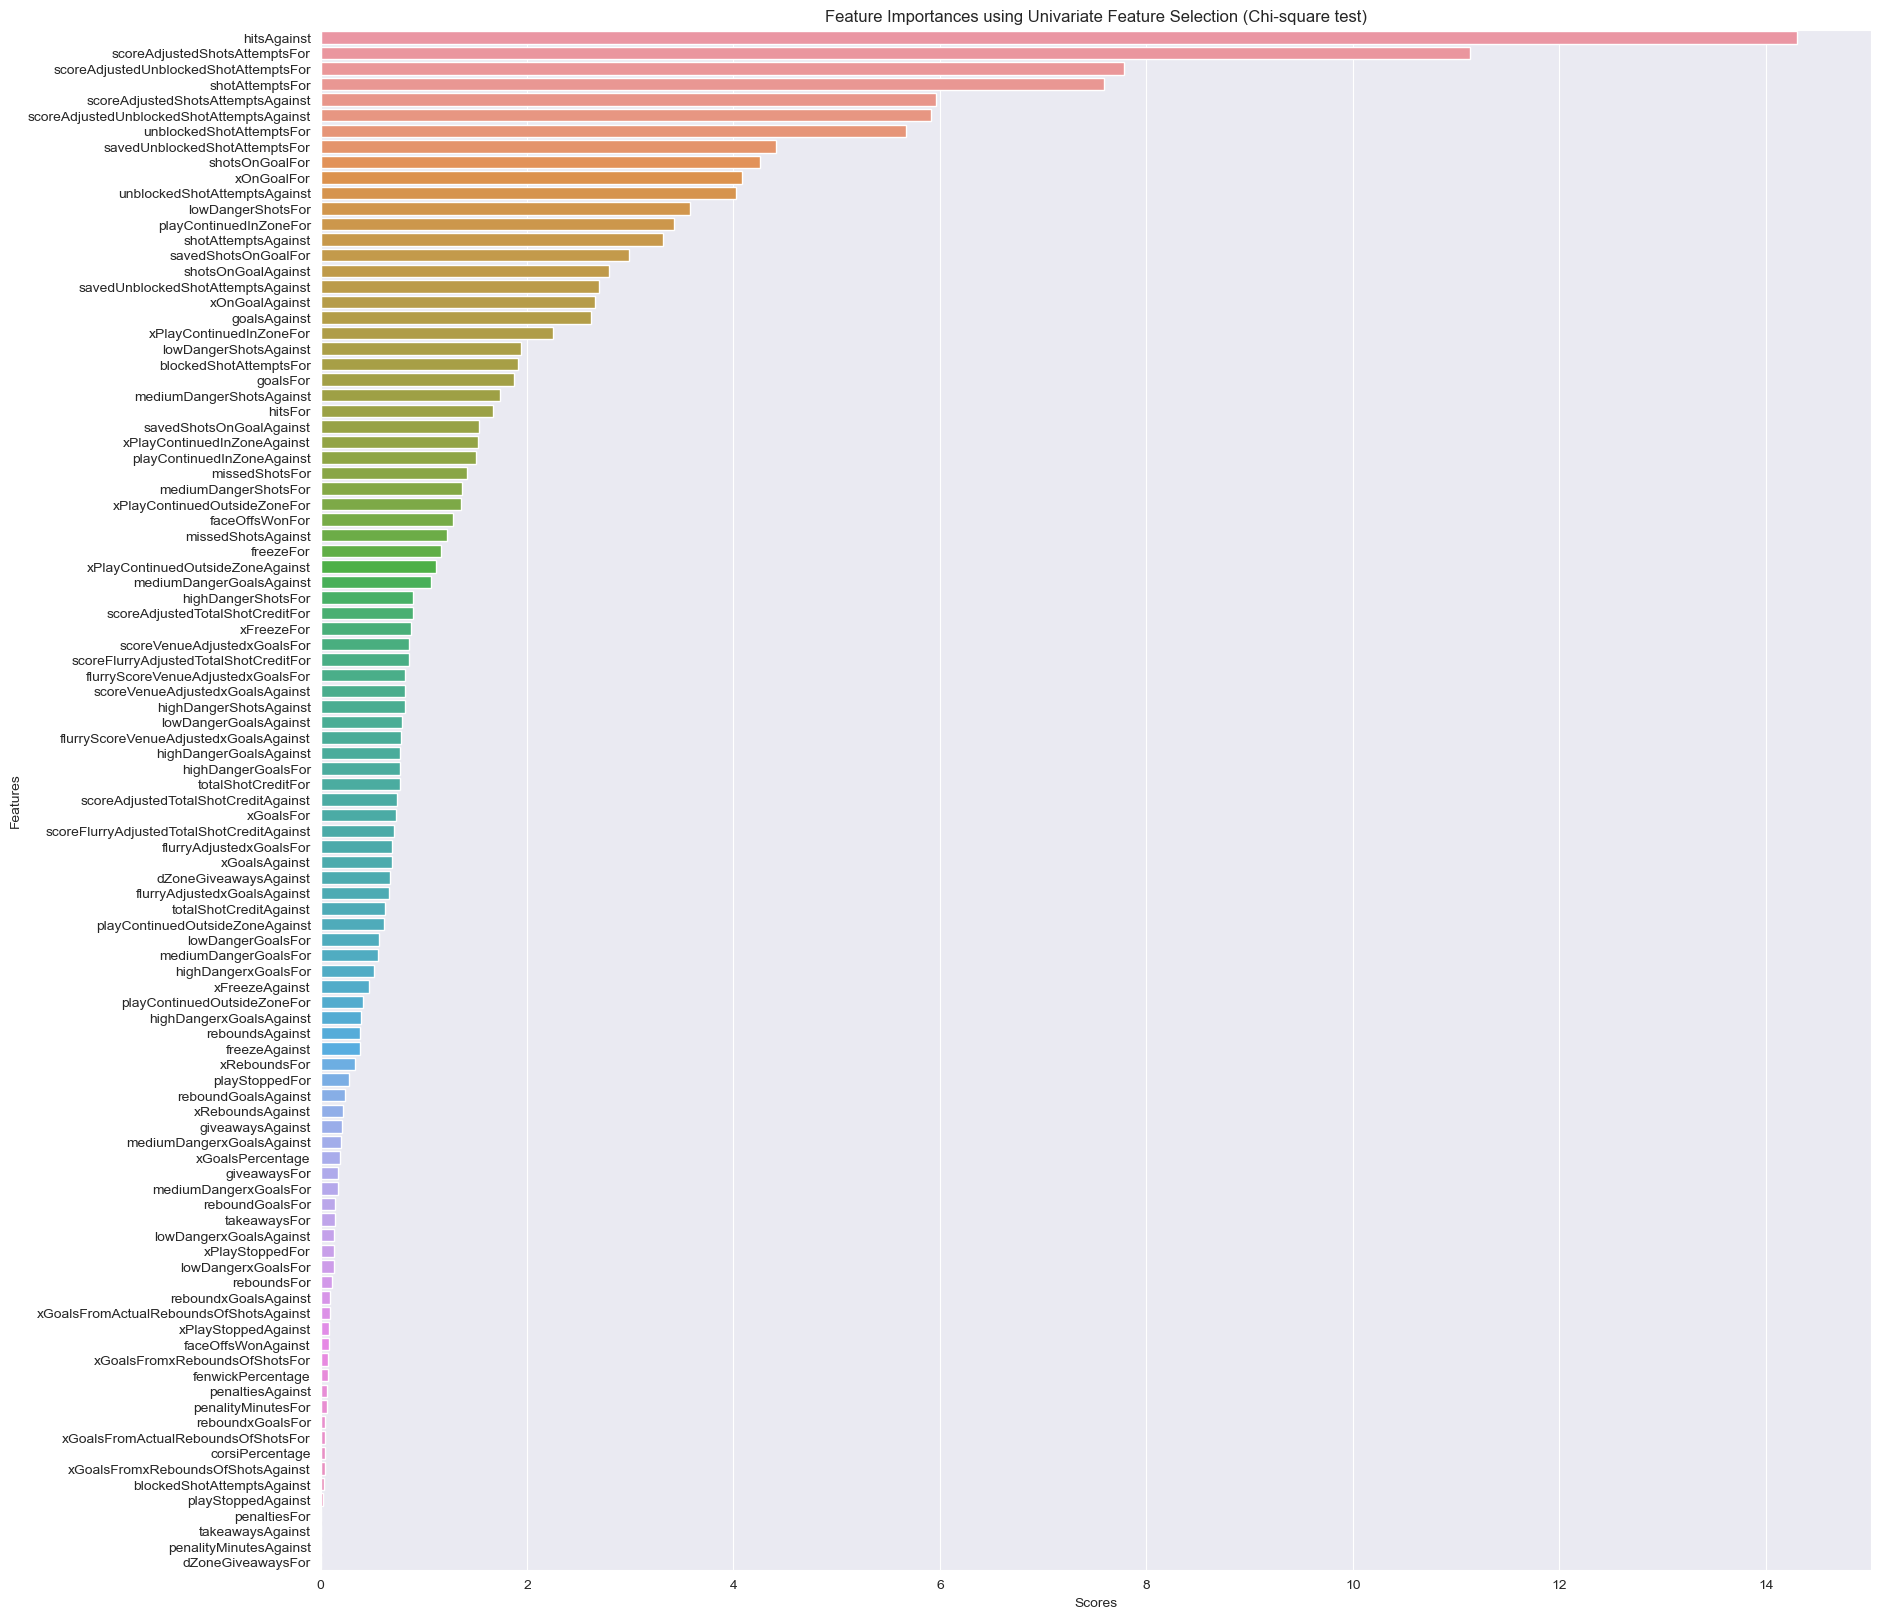

In [1069]:
# apply univariate feature selection
best_features = SelectKBest(score_func=chi2, k=5).fit(X, y)

# get the scores and selected features
scores = best_features.scores_
selected_features = X.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(X.columns)[sorted_idxs]

print(pd.DataFrame({"feature": sorted_feature_names, "score": sorted_scores}))

# plot scores
plt.figure(figsize=(20, 20))
sns.barplot(x=sorted_scores, y=sorted_feature_names)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (Chi-square test)')
plt.show()

In [1070]:
class MyKNearestNeighborsClassifier:
    pass

    def __init__(self, k):
        self.k = self.__validate_k(k)
        self.x_train = None
        self.y_train = None

    def fit(self, x_train, y_train):
        # np.unique(y) # classes
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        predicted_points = []
        for test_x_point in x_test:
            predicted_points.append(self.__predict_class(test_x_point))
        return np.array(predicted_points)

    def __predict_class(self, x_point):
        distances = []
        # calculate distances to all the training points
        for x_train_point in self.x_train:
            distances.append(self.__euclidean(x_train_point, x_point))

        nearest_indexes = np.argsort(distances)[:self.k]  # sort distances, take k nearest points' indices
        nearest_classes = self.y_train[nearest_indexes]  # take their classes
        # count number of occurrences of a class and return the index of max counter.
        return np.bincount(nearest_classes).argmax()

    def __euclidean(self, point1, point2):
        distance = np.sum(np.square(point1 - point2))
        return np.sqrt(distance)

    def __validate_k(self, k):
        if k <= 0:
            raise Exception("K cannot be less or equal to zero")

        k += 1  # Ties can be broken consistently by expanding K by 1
        return k

In [1071]:
def try_knn(n_neighbors, train_x, train_y, test_x):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    classifier.fit(train_x, train_y)
    return classifier


def try_my_knn(n_neighbors, train_x, train_y, test_x):
    classifier = MyKNearestNeighborsClassifier(n_neighbors)
    classifier.fit(train_x, train_y)
    return classifier


def try_decision_tree(max_depth, train_x, train_y, test_x):
    classifier = DecisionTreeClassifier(max_depth=max_depth)
    classifier.fit(train_x, train_y)
    return classifier


def try_voting(k_dept, train_x, train_y, test_x, voting_type):
    classifier_knn = KNeighborsClassifier(n_neighbors=k_dept, metric='euclidean')
    classifier_knn.fit(train_x, train_y)
    classifier_dec_tree = DecisionTreeClassifier(max_depth=k_dept)
    classifier_dec_tree.fit(train_x, train_y)
    voting_clf_hard = VotingClassifier(estimators=[('knn', classifier_knn), ('decision_tree', classifier_dec_tree)],
                                       voting=voting_type)
    voting_clf_hard.fit(train_x, train_y)
    return voting_clf_hard


def plot_prediction(test_y, pred_y):
    plt.figure(figsize=(10, 5))
    plt.plot(test_y, label='true')
    plt.plot(pred_y, label='prediction')
    plt.xlabel('Scores')
    plt.ylabel('Features')
    plt.legend()


In [1072]:
class ModelMetrics:
    def __init__(self, train_x, test_x, train_y, test_y, pred_y, classifier_name, k_or_depth, splits, test_s,
                 classifier_instance):
        self.pred_y = pred_y
        self.train_x = train_x
        self.test_x = test_x
        self.train_y = train_y
        self.test_y = test_y
        self.classifier_name = classifier_name
        self.k_or_depth = k_or_depth
        self.splits = splits
        self.test_s = test_s
        self.classifier_instance = classifier_instance
        self.classes = np.unique(pred_y)
        self.precision = precision_score(test_y, pred_y, average=None)
        self.recall = recall_score(test_y, pred_y, average=None)
        self.accuracy = accuracy_score(test_y, pred_y)
        self.confusion_matrix = confusion_matrix(test_y, pred_y)
        self.f1_score = f1_score(test_y, pred_y)
        self.testing_error = mean_absolute_error(test_y, pred_y)

    def comparator(a, b):
        return a.f1_score - b.f1_score

    def get_classifier_instance(self):
        return self.classifier_instance

    def __str__(self):
        return (
            f'| {self.classifier_name:>11}| {self.k_or_depth:>4} | {self.splits:>10}| {self.test_s:>10}| {self.f1_score:>20} | {self.accuracy:>20} |  {self.precision.__str__():>23} | {self.recall.__str__():>23} |{self.testing_error:>20} |')

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.test_y, label='true')
        plt.plot(self.pred_y, label='prediction')
        plt.xlabel(f'Scores of {self.classifier_name}')
        plt.ylabel('Features')
        plt.legend()


class ModelChooser:
    def __init__(self):
        self.data = []

    def get_data(self):
        return self.data

    def push(self, train_x, test_x, train_y, test_y, classif, classifier_name, k_d, s_count, test_size_c):
        self.data.append(
            ModelMetrics(train_x, test_x, train_y, test_y, classif.predict(test_x), classifier_name, k_d, s_count,
                         test_size_c, classif))

    def append(self, chooser):
        for item in chooser.data:
            self.data.append(item)

    def append_metrics(self, model_metrics):
        self.data.append(model_metrics)

    def get_k_best(self, k):
        data = sorted(self.data, key=cmp_to_key(ModelMetrics.comparator), reverse=True)
        return data[:k]

    def print_k_best(self, k):
        print(
            f'| {"":>4}| {"Classifier":>10} | {"k":>4} | {"split size":>10}| {"test size":>8} | {"f1":>20} | {"accuracy":>20} | {"precision":>24} | {"recall":>23} | {"test error":>20} |')
        for i, model in enumerate(self.get_k_best(k)):
            print(f'|{i + 1:>4} {model}')




In [1073]:
def run_evaluation(x_data, y_data, selected_important_features):
    x_vals = x_data[selected_important_features].values
    y_vals = y_data.values

    model_chooser_knn = ModelChooser()
    model_chooser_my_knn = ModelChooser()
    model_chooser_dec_tree = ModelChooser()
    model_chooser_hard_voting = ModelChooser()
    model_chooser_soft_voting = ModelChooser()

    for splits_count in split_count_range:
        for test_size_count in range(0, len(test_size_array)):
            test_size = test_size_array[test_size_count]
            # cross validation repeats the split such that the training and test sets are different for each evaluation
            # evaluate the variability of our estimation of generalization performance
            cvsplt = StratifiedShuffleSplit(n_splits=splits_count, test_size=test_size, random_state=0)
            for train_index, test_index in cvsplt.split(x_vals, y_vals):
                x_train, x_test = x_vals[train_index], x_vals[test_index]
                y_train, y_test = y_vals[train_index], y_vals[test_index]

                for idx in k_or_depth_range:
                    knn_classifier = try_knn(idx, x_train, y_train, x_test)
                    my_knn_classifier = try_my_knn(idx, x_train, y_train, x_test)
                    dec_tree_classifier = try_decision_tree(idx, x_train, y_train, x_test)
                    hard_voting_classifier = try_voting(idx, x_train, y_train, x_test, 'hard')
                    soft_voting_classifier = try_voting(idx, x_train, y_train, x_test, 'soft')

                    model_chooser_knn.push(x_train, x_test, y_train, y_test, knn_classifier, f'KNN', idx, splits_count,
                                           test_size)
                    model_chooser_my_knn.push(x_train, x_test, y_train, y_test, my_knn_classifier, f'myKNN', idx,
                                              splits_count, test_size)
                    model_chooser_dec_tree.push(x_train, x_test, y_train, y_test, dec_tree_classifier, f'DecTree', idx,
                                                splits_count, test_size)
                    model_chooser_hard_voting.push(x_train, x_test, y_train, y_test, hard_voting_classifier, f'HardVot',
                                                   idx, splits_count, test_size)
                    model_chooser_soft_voting.push(x_train, x_test, y_train, y_test, soft_voting_classifier, f'SoftVot',
                                                   idx, splits_count, test_size)

    return model_chooser_knn, model_chooser_my_knn, model_chooser_dec_tree, model_chooser_hard_voting, model_chooser_soft_voting

In [1074]:
def get_best_model(x_val_data, y_val_data, features_vector):
    knn_models, my_knn_models, dec_tree_models, hard_vot_models, soft_vot_models = run_evaluation(x_val_data,
                                                                                                  y_val_data,
                                                                                                  features_vector)
    top_models_count = 1
    print(f'KNN')
    knn_models.print_k_best(top_models_count)
    print(f'myKNN')
    my_knn_models.print_k_best(top_models_count)
    print(f'Decision Tree')
    dec_tree_models.print_k_best(top_models_count)
    print(f'Hard Voting')
    hard_vot_models.print_k_best(top_models_count)
    print(f'Soft Voting')
    soft_vot_models.print_k_best(top_models_count)

    total = ModelChooser()
    total.append(knn_models)
    total.append(my_knn_models)
    total.append(dec_tree_models)
    total.append(hard_vot_models)
    total.append(soft_vot_models)
    print(f'Overall best')
    total.print_k_best(top_models_count)

    return total.get_k_best(1)

In [1075]:
sorted_features_with_scores = pd.DataFrame({"feature": sorted_feature_names, "score": sorted_scores})
sorted_features_with_scores = sorted_features_with_scores[sorted_features_with_scores['score'] > 1.0]
important_features = sorted_features_with_scores["feature"].values

split_count_range = range(3, 10)
test_size_array = [0.2, 0.3]
k_or_depth_range = range(3, 10)

print(f'based on the following features {important_features}')

model_data = get_best_model(X, y, important_features)
print(f'The best is\n{model_data[0]}')

based on the following features ['hitsAgainst' 'scoreAdjustedShotsAttemptsFor'
 'scoreAdjustedUnblockedShotAttemptsFor' 'shotAttemptsFor'
 'scoreAdjustedShotsAttemptsAgainst'
 'scoreAdjustedUnblockedShotAttemptsAgainst' 'unblockedShotAttemptsFor'
 'savedUnblockedShotAttemptsFor' 'shotsOnGoalFor' 'xOnGoalFor'
 'unblockedShotAttemptsAgainst' 'lowDangerShotsFor'
 'playContinuedInZoneFor' 'shotAttemptsAgainst' 'savedShotsOnGoalFor'
 'shotsOnGoalAgainst' 'savedUnblockedShotAttemptsAgainst' 'xOnGoalAgainst'
 'goalsAgainst' 'xPlayContinuedInZoneFor' 'lowDangerShotsAgainst'
 'blockedShotAttemptsFor' 'goalsFor' 'mediumDangerShotsAgainst' 'hitsFor'
 'savedShotsOnGoalAgainst' 'xPlayContinuedInZoneAgainst'
 'playContinuedInZoneAgainst' 'missedShotsFor' 'mediumDangerShotsFor'
 'xPlayContinuedOutsideZoneFor' 'faceOffsWonFor' 'missedShotsAgainst'
 'freezeFor' 'xPlayContinuedOutsideZoneAgainst' 'mediumDangerGoalsAgainst']
KNN
|     | Classifier |    k | split size| test size |                   f1 |  

In [1076]:

X_2023_vals = X_2023[important_features].values
print(model_data[0].classifier_instance)
prediction_2023 = model_data[0].classifier_instance.predict(X_2023_vals)
prediction_2023_table = pd.DataFrame({"team": teams['team'].values, "qualified": prediction_2023})
print(prediction_2023_table)

DecisionTreeClassifier(max_depth=3)
   team  qualified
0   VAN          0
1   BUF          0
2   STL          0
3   BOS          0
4   DET          0
5   ANA          0
6   FLA          0
7   WPG          0
8   NSH          0
9   WSH          0
10  SJS          0
11  LAK          0
12  NYR          0
13  OTT          0
14  VGK          0
15  NYI          0
16  TOR          0
17  SEA          0
18  CAR          0
19  DAL          0
20  MTL          0
21  EDM          0
22  TBL          0
23  CHI          0
24  PHI          0
25  CGY          0
26  NJD          0
27  CBJ          0
28  COL          0
29  MIN          0
30  PIT          0
31  ARI          0
